# Foreign Exchange Forecasting using LSTMs

In [1]:
import pandas as pd
import numpy as np

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

2023-08-24 20:30:09.958829: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 20:30:10.230393: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 20:30:11.398965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Google Spreadsheet ID
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = ['USD/IDR', 'EUR/IDR', 'JPY/IDR']

# USD-IDR

## Data Overview
From Google Finance

In [3]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME[0]}'
df = pd.read_csv(url)

# Drop unused columns
df = df.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1977 entries, 0 to 1976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1977 non-null   datetime64[ns]
 1   Close   1977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


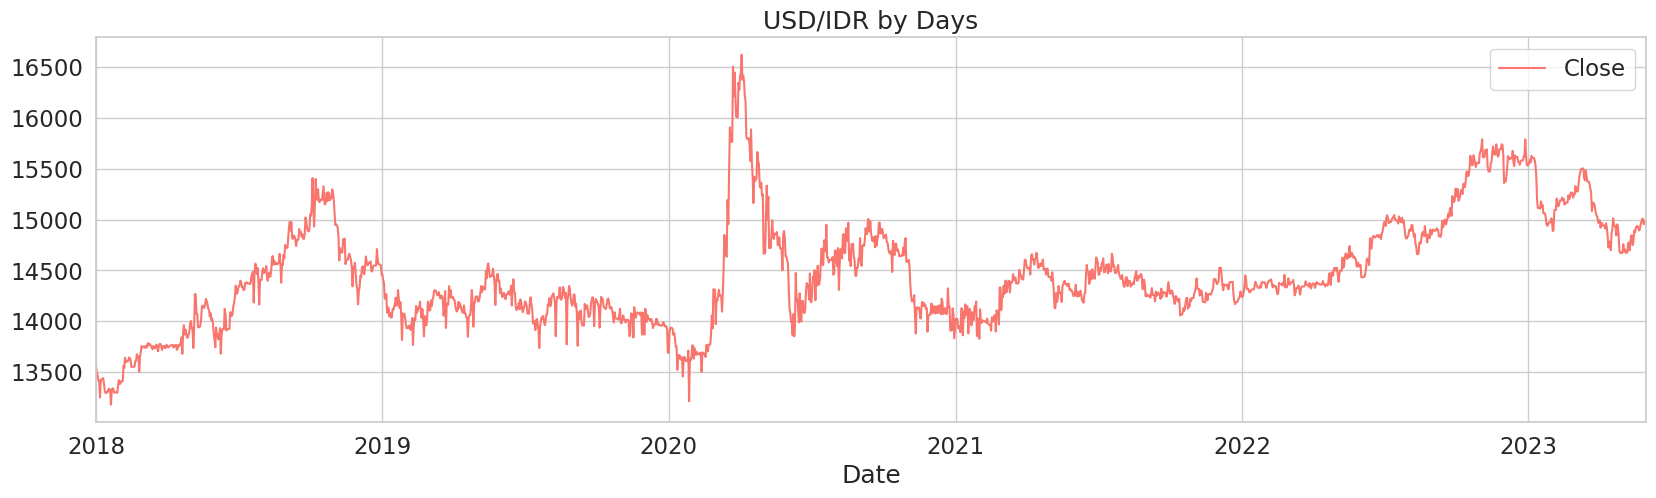

In [4]:
dfplot = df.copy()
dfplot = dfplot.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
dfplot = dfplot.set_index('Date')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = dfplot.plot(style='', figsize=(20,5), color=color_pal[0], title='USD/IDR by Days')

## Data preprocessing

In [5]:
scaler = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close.shape

(1977, 1)

## Making sequences

In [6]:
SEQ_LEN = 6
SPLIT = 0.90

def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)

def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = SPLIT)

## Building LSTM model

In [7]:
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(units=1))

2023-08-24 20:30:16.017813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 20:30:16.165649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 20:30:16.165939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 20:30:16.169186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 20:30:16.169425: I tensorflow/compile

## Training

In [8]:
BATCH_SIZE = 32
EPOCH = 50
VAL_SPLIT = 0.1

model.compile(
    loss='mse',
    metrics=['mae', RootMeanSquaredError()],
    optimizer='adam',
)
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_split=VAL_SPLIT)

Epoch 1/50


2023-08-24 20:30:19.192116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 20:30:19.194196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 20:30:19.195115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

48/50 [===========================>..] - ETA: 0s - loss: 0.0193 - mae: 0.0979 - root_mean_squared_error: 0.1389

2023-08-24 20:30:28.962941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 20:30:28.964699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 20:30:28.965567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

50/50 [==============================] - 11s 42ms/step - loss: 0.0187 - mae: 0.0957 - root_mean_squared_error: 0.1367 - val_loss: 0.0092 - val_mae: 0.0877 - val_root_mean_squared_error: 0.0958
Epoch 2/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0018 - mae: 0.0298 - root_mean_squared_error: 0.0428 - val_loss: 6.2593e-04 - val_mae: 0.0201 - val_root_mean_squared_error: 0.0250
Epoch 3/50
50/50 [==============================] - 1s 13ms/step - loss: 0.0016 - mae: 0.0268 - root_mean_squared_error: 0.0396 - val_loss: 8.9667e-04 - val_mae: 0.0249 - val_root_mean_squared_error: 0.0299
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.0015 - mae: 0.0267 - root_mean_squared_error: 0.0393 - val_loss: 9.0703e-04 - val_mae: 0.0250 - val_root_mean_squared_error: 0.0301
Epoch 5/50
50/50 [==============================] - 1s 15ms/step - loss: 0.0015 - mae: 0.0261 - root_mean_squared_error: 0.0389 - val_loss: 7.8124e-04 - val_mae: 0.0229 - val_root_mean_s

In [9]:
model.evaluate(X_test, y_test)

1/7 [===>..........................] - ETA: 0s - loss: 0.0014 - mae: 0.0335 - root_mean_squared_error: 0.0372

7/7 [==============================] - 0s 10ms/step - loss: 7.6120e-04 - mae: 0.0234 - root_mean_squared_error: 0.0276


[0.0007612010813318193, 0.02342827618122101, 0.027589872479438782]

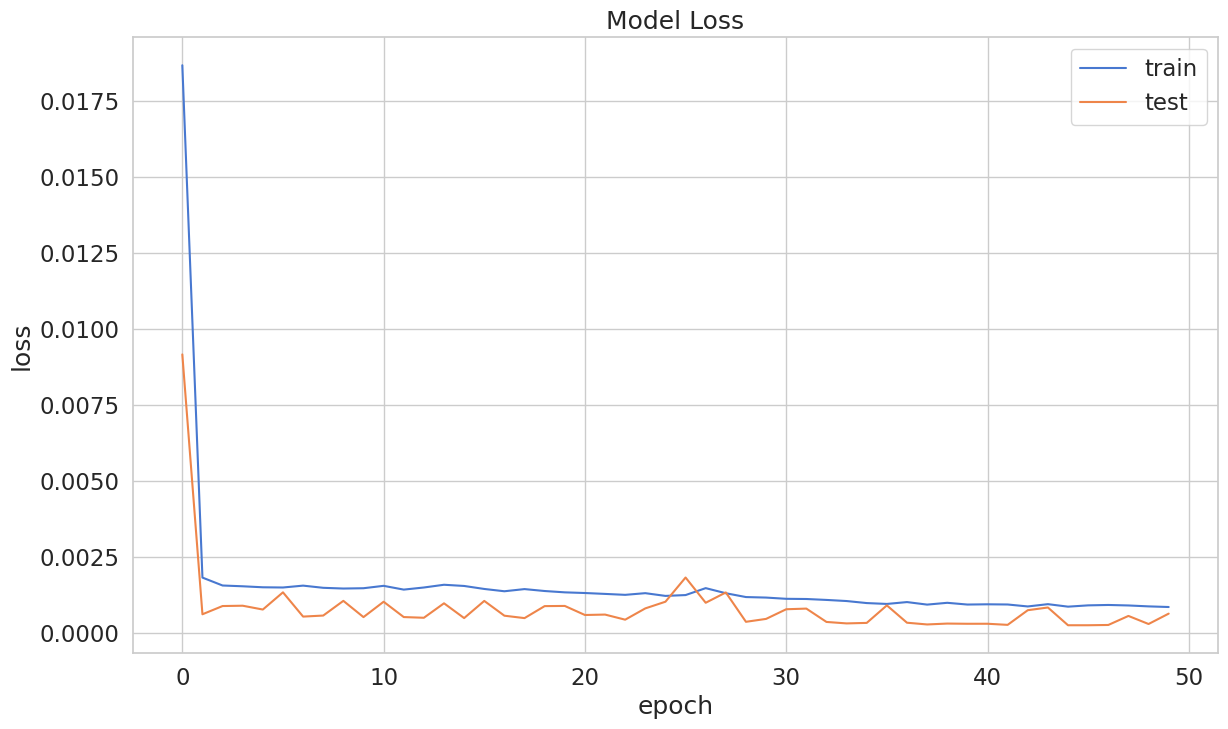

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

## Prediction

In [11]:
y_hat = model.predict(X_test)
y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)

2023-08-24 20:31:05.958326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 20:31:05.959904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 20:31:05.961060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/7 [===>..........................] - ETA: 3s

2023-08-24 20:31:06.237091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 20:31:06.238735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 20:31:06.239850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 6ms/step


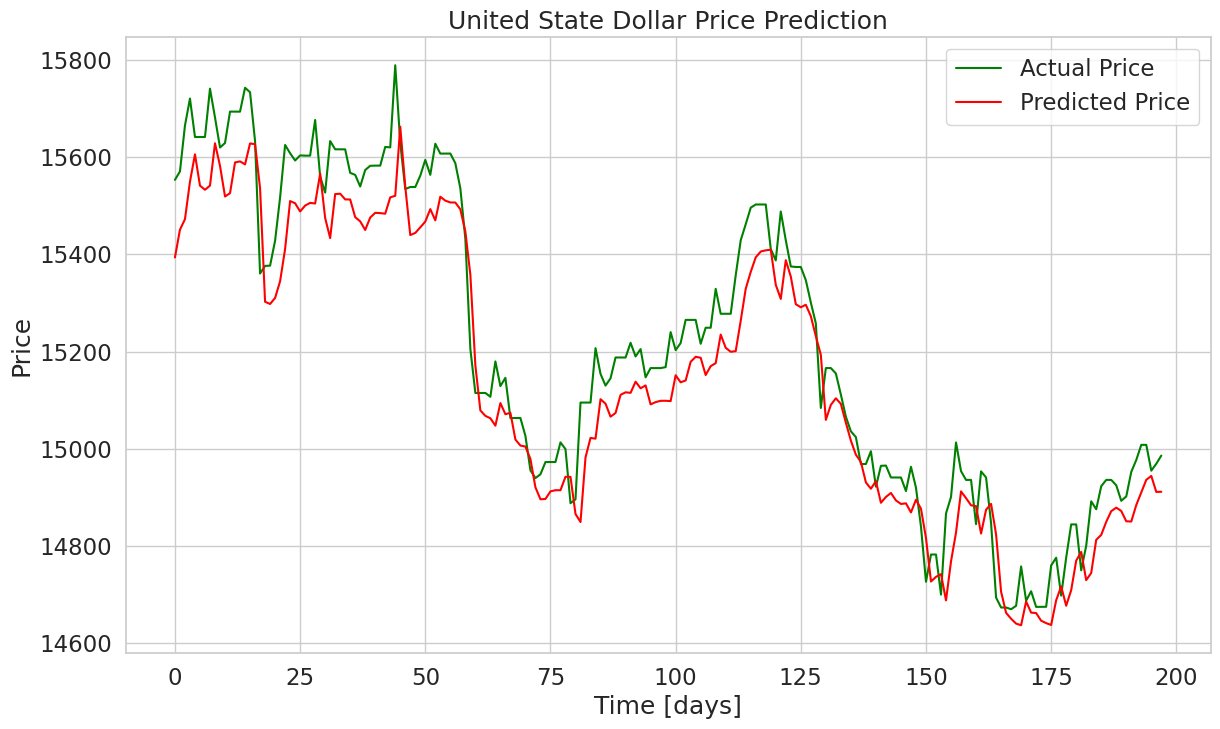

In [12]:
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('United State Dollar Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [13]:
def matrices(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print("Mean Squared Error for prediction :", mse)
    print("Mean Absolute Error for prediction :", mae)
    print("Root Mean Squared Error for prediction :", rmse)

print("----------------- Normalized Error -----------------")
matrices(y_test, y_hat)
print("----------------- Actual Error -----------------")
matrices(y_test_inverse, y_hat_inverse)

----------------- Normalized Error -----------------
Mean Squared Error for prediction : 0.0007612009777222782
Mean Absolute Error for prediction : 0.023428274509869094
Root Mean Squared Error for prediction : 0.027589870926161983
----------------- Actual Error -----------------
Mean Squared Error for prediction : 9024.523862400678
Mean Absolute Error for prediction : 80.66830808080826
Root Mean Squared Error for prediction : 94.99749397958179
